In [1]:
from matplotlib import pyplot as plt
import numpy as np

from src.image_process.image_io import LoadImage

import src.image_process.pre_process as prep

import src.image_process.mask.mask_getters as maget

from src.image_process.edp_center.center_optimization.opt_funcs import Area
from src.image_process.edp_center.centroid import get_centroid
from src.image_process.edp_center.center_optimization.optimization import optimize_center

from src.image_process.diffraction_pattern import eDiffractionPattern
from src.image_process.polar.polar_representation import PolarRepresentation
from src.image_process.polar.rotational_average import RotationalAverage

In [101]:
file_path = 'data/285 mm 64f 1_5s SnO2b.dm3'
load_image = LoadImage(file_path=file_path)

data = load_image.data

In [111]:
mean_mask = maget.MeanTreshMask(.1)
mask = maget.superpose_masks(data, [mean_mask])

In [112]:
penalty_func = Area(data, mask).get_penalty_func()
centroid = get_centroid(data)
center = optimize_center(penalty_func, data.shape, initial_guess=centroid)
center

(1169.0000037977695, 977.9999999926043)

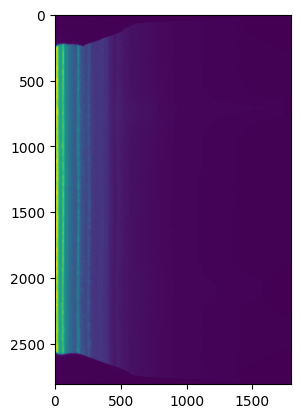

In [113]:
edp = eDiffractionPattern(data, center, mask)
polar_representation = PolarRepresentation(edp=edp)

polar_representation.radial_range = (0.06, 0.7)

plt.imshow(polar_representation.polar_image)

In [114]:
rotational_average = RotationalAverage(polar_representation=polar_representation)
np.max(rotational_average.get_rotational_average(50, 300))

51793.824

In [106]:
from src.image_process.ellipse.elp_params import EllipseParams

ellipse_params = EllipseParams(edp=edp)


In [107]:
params = ellipse_params.measure_ellipse_params()
params

{'axis_ratio': 1.0379081142848274, 'orientation': 8.272551971468634}

In [108]:
from src.image_process.ellipse.elp_correction import correct_ellipse

res = correct_ellipse(edp = edp, ellipse_params = params)

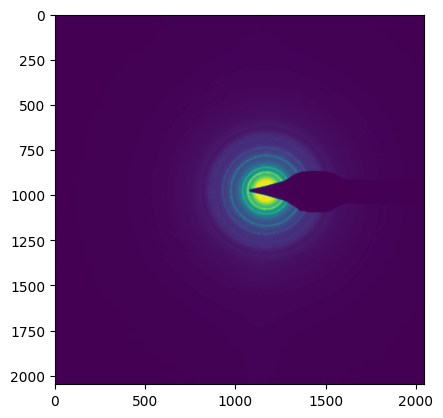

In [109]:
plt.imshow(res)

In [110]:
data = res.copy()